# Projet Python pour la data science

### Auteurs: Arthur LEROUDIER, Romane LE POTIER

##### L'objectif de ce notebook est de présenter le projet que nous avons effectué dans le cadre de l'unité d'enseignement Python pour la data science à l'ENSAE. Ce projet contient une première partie sur la récupération d'une base de données par web scraping puis une seconde partie nettoyage de la base de données et visualisation et une dernière partie sur la modélisation.

# Quelle est l'importance d'un joueur sur l'issu d'un match de basket ?

##### Pour répondre à cette problématique, nous allons étudier les statistiques de joueurs sur 10 matchs de basket, puis prendre la moyenne des statistiques d'un joueur sur la saison et modéliser la probabilité de gagner le match quand ce joueur est sur le terrain. Dans notre cas, on a choisi Victor Wembanyama qui est un joueur français qui fait sa 1ère saison en NBA.

## Installation préalable

In [4]:
!pip install -q lxml
!pip install webdriver-manager

## Importation des modules utiles

In [5]:
import bs4
import lxml
import pandas as pd
from urllib import request
import os
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier

# Récupération et traitement des données

## Extraction des données de 10 matchs de basket par web scraping

##### On a décidé d'extraire les tableaux de données sur le site basketball reference des 10 matchs qui ont eu lieu le 25 octobre 2023.

In [8]:
# à changer pour chaque match avec 1 qui veut dire match gagné et 0 match perdu
url_match="http://bkref.com/pi/shareit/WumlT"
titre = 'Orlando'
result = 1

In [9]:
request_text = request.urlopen(url_match).read()
#print(request_text[:1000])
page = bs4.BeautifulSoup(request_text, "lxml")
#print(page)

tableau_match = page.find('table', {'class' : 'sortable stats_table now_sortable modifying'})
#print(tableau_match)

table_body = tableau_match.find('tbody')
rows = table_body.find_all('tr')
#print(rows[1])

for row in rows:
    cols = row.find_all('td')
    cols = [ele.text.strip() for ele in cols]
    #print(cols)

dico_participants = dict()
for row in rows:
    nom = row.find_all('th')
    nom = [ele.text.strip() for ele in nom]
    cols = row.find_all('td')
    cols = [ele.text.strip() for ele in cols]
    cols = nom + cols
    if len(cols) > 0 : 
        dico_participants[cols[0]] = cols[1:]
#dico_participants

table_head = tableau_match.find('thead')
titres_col = table_head.find_all('th')
titres_col = [ele.text.strip() for ele in titres_col[3:]]
#print(titres_col)

data_participants = pd.DataFrame.from_dict(dico_participants,orient='index', columns = titres_col)
data_participants['Résultat'] = [result for index in range(data_participants.shape[0])]
data_participants.to_csv('data/'+titre+'_Stats.csv')
print(data_participants)

FeatureNotFound: Couldn't find a tree builder with the features you requested: lxml. Do you need to install a parser library?

##### On a donc effectué ce code 20 fois pour les 20 équipes différentes en rajoutant aux données la dernière colonne résultat. Ces 20 tableaux se trouvent dans le dossier data.

##### Pour chaque tableau, on a à gauche le nom des joueurs et pour les colonnes:
##### MP: temps joué dans le match
##### FG: tirs marqués à 2 points
##### FGA: tirs tentés à 2 points
##### FG%: pourcentage de réussite à 2 points
##### 3P: tirs marqués à 3 points
##### 3PA: tirs tentés à 3 points
##### 3P%: pourcentage de réussite à 3 points
##### FT: lancers francs marqués
##### FTA: lancers francs tentés
##### FT%: pourcentage de lancers francs réussis
##### ORB: nombre de rebonds offensifs
##### DRB: nombre de rebonds défensifs
##### TRB: nombre de rebonds totaux
##### AST: nombre de passs décisives
##### STL: nombre d'interceptions
##### BLK: nombre de contres
##### TOV: nombre de balles perdues
##### PF: nombre de fautes commises
##### PTS: nombre de points marqués
##### +/-: différence de points marqués entre les deux équipes quand le joueur  est sur le terrain
##### Résultat: 1 si match gagné, 0 sinon

# Nettoyage de la base de données

In [10]:
#commande à n'exécuter qu'une fois
os.chdir('data/')

### On commence par concaténer nos 20 tableaux en un seul tableau.

In [11]:
#on prend la liste des fichiers
files = [f for f in os.listdir('.') if os.path.isfile(f)]
data = pd.read_csv(files[0])
#la colonne +/- n'est pas prise en compte car on a pas sa moyenne pour les matchs de Wembanyama
data = data.loc[:, data.columns!='+/-']
#conversion des minutes par match en flottant
data.loc[:,'MP'] = [float(x.split(':')[0])+ 0.006*float(x.split(':')[1]) for x in data.loc[:,'MP']]
#concatenation de toutes les tables csv en un seul tableau
for file in files[1:]:
    match = pd.read_csv(file)
    match = match.loc[:,match.columns!='+/-']
    match.loc[:,'MP'] = [float(x.split(':')[0])+ 0.006*float(x.split(':')[1]) for x in match.loc[:,'MP']]
    data = pd.concat([data,match])
data.reset_index(drop=True, inplace=True)

print("nombre d'individus: ", len(data.index))

nombre d'individus:  223


##### On a donc les données d'un match pour 223 joueurs différents.

##### Pour certains joueurs, des informations manquent et des cases du tableau sont donc vides. On remplace ces cases vides par une donnée de la même colonne pour des joueurs ayant la même valeur dans la colonne résultat.

In [12]:
#imputation des données manquantes
#remplace les données absentes par une donnée de la même colonne, avec la même valeur pour la variable Résultat
data_win = data[data['Résultat'] == 1]
data_lose = data[data['Résultat'] != 1]
for col in data_win.columns:
    for i,rows in data_win.iterrows():
        if pd.isna(data_win.loc[i,col]):
            data_win.loc[i,col] = np.random.choice(data_win[data_win[col].notna()].loc[:,col])
for col in data_lose.columns:
    for i,rows in data_lose.iterrows():
        if pd.isna(data_lose.loc[i,col]):
            data_lose.loc[i,col] = np.random.choice(data_lose[data_lose[col].notna()].loc[:,col])
data = pd.concat([data_win,data_lose])

X_train = data.loc[:, data.columns!='Résultat']
X_train = X_train.iloc[:,1:]
Y = data.loc[:,'Résultat']
VW = np.array([30.2 ,6.9 ,15.9 ,0.435 ,1.4 ,4.9 ,0.278 ,3.3 ,4.2 ,0.774 ,2.3 ,8.4 ,10.7 ,2.8 ,1.4 ,3.0 ,3.3 ,2.5 ,18.5])

# Visualisation

##### On trace les histogrammes de répartitions des différentes variables d'analyse selon si l'individu a gagné son match ou non.

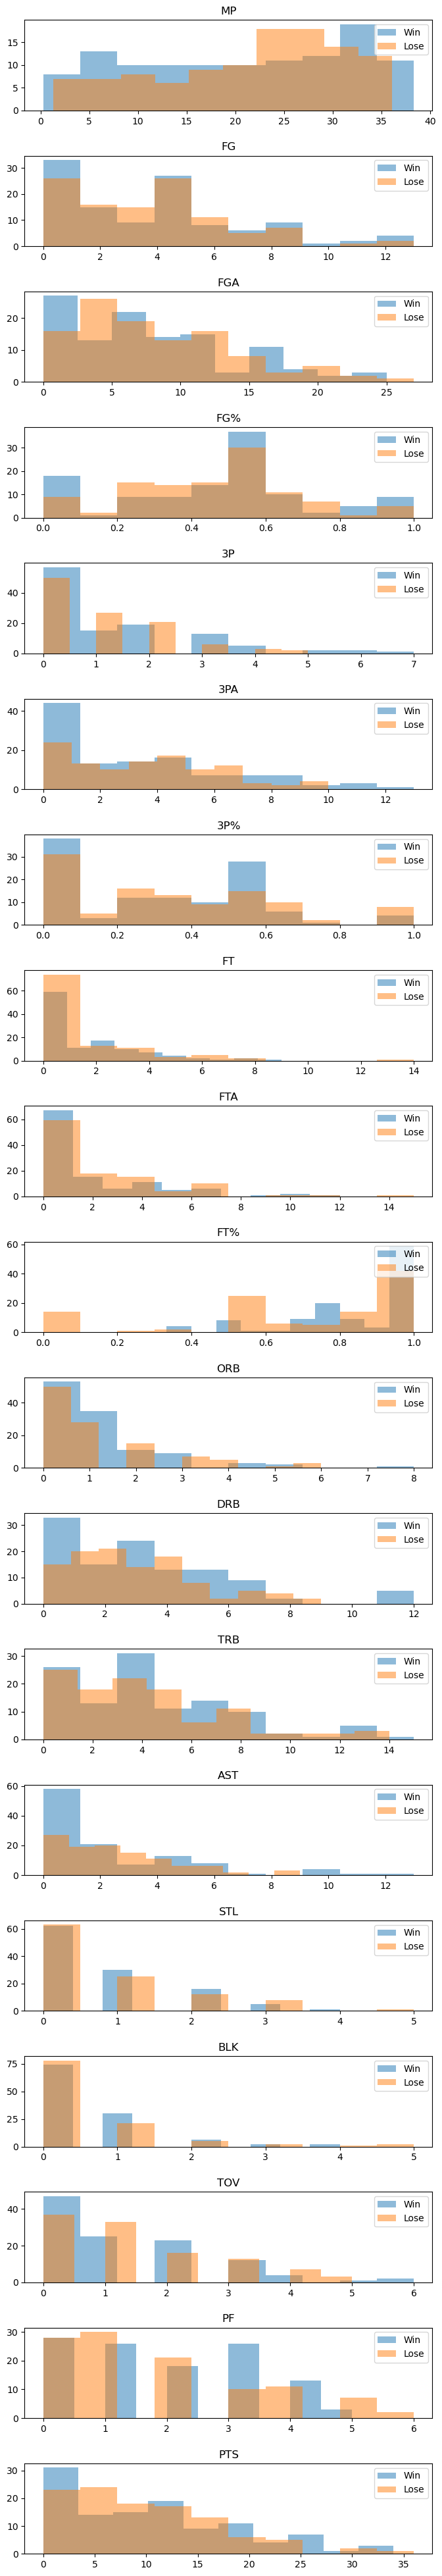

In [13]:
plt.figure(figsize=(8, 50))
lignes = len(data.iloc[:,1:-1].columns)
plt.subplots_adjust(hspace=0.5)

for n,col in enumerate(data.iloc[:,1:-1].columns):
    ax = plt.subplot(lignes, 1, n+1)
    Win = data.loc[data['Résultat'] == 1, col]
    Lose = data.loc[data['Résultat'] == 0, col]
    ax.hist(Win, alpha = 0.5, label  = 'Win')
    ax.hist(Lose, alpha = 0.5, label = 'Lose')
    ax.legend(loc='upper right')
    ax.set_title(col)
plt.show()

# Modélisation

##### On commence par normer et centrer les variables afin de pouvoir réaliser une régression linéaire par la suite.

In [12]:
#Standardisation
scaler = sk.preprocessing.StandardScaler().fit(X_train)
X_scaled = scaler.transform(X_train)

In [13]:
#régression linéaire
reg = LinearRegression().fit(X_scaled, Y)
for k in range(len(reg.coef_)):
    print('coef de ',data.columns[k], ':', reg.coef_[k])
print('constante: ',reg.intercept_)

coef de  Unnamed: 0 : -0.10200421522531417
coef de  MP : 0.03021895237398286
coef de  FG : -0.06379910922837341
coef de  FGA : 0.005506828738304873
coef de  FG% : 0.18345760804905095
coef de  3P : -0.09530994272002209
coef de  3PA : -0.1023533005264111
coef de  3P% : -0.05642665356313856
coef de  FT : 0.03806785926906024
coef de  FTA : 0.16229592936445797
coef de  FT% : -0.016127075200177803
coef de  ORB : 0.03587919674640999
coef de  DRB : 0.02084757255931242
coef de  TRB : 0.028133664249904093
coef de  AST : 0.012168011040625641
coef de  STL : 0.00929187981933716
coef de  BLK : -0.012621348319038135
coef de  TOV : 0.02723027554497316
coef de  PF : 0.03998411397410368
constante:  0.5112107623318385


##### Ainsi, on obtient les coefficients des variables. Cependant, on peut remarquer que les résultats sont peu pertinents. Cela est dû au fait que la quantité à prédire est un booléen.

##### Il paraît donc plus judicieux de réaliser une régression logistique puisqu'un réseau de neurone à 1 neurone fonctionne comme une régression linéaire mais prédit un booléen.

In [14]:
#régression logistique
clf = LogisticRegression(random_state=0).fit(X_scaled, Y)
VW = VW.reshape(1, -1)
print(np.shape(VW))
print('prédiction: ', clf.predict(VW))
print('proba de perdre: ', clf.predict_proba(VW)[0][0])
print('proba de gagner: ', clf.predict_proba(VW)[0][1])

(1, 19)
prédiction:  [0]
proba de perdre:  0.9999675979580431
proba de gagner:  3.2402041956826914e-05


##### On trouve alors un résultat très catégorique: on est sûr de perdre. Cependant, ce résultat n'est pas fiable à cause de la "faible" quantité d'individus d'entraînement.

##### Il nous paraît alors plus pertinent d'effectuer un arbre de décision puisque c'est un algorithme de ML qui crée un arbre de décision en séparant au mieux les données d'entraînement selon le booléen à prédire.

In [15]:
#arbre de décision
clf = tree.DecisionTreeClassifier(max_depth=6)
clf = clf.fit(X_scaled, Y)
print('Les résultats suivants ne sont pas consistants suivant la séparation entrainement/vérif')
print('prédiction: ', clf.predict(VW))
print('proba de perdre: ', clf.predict_proba(VW)[0][0])
print('proba de gagner: ', clf.predict_proba(VW)[0][1])

Les résultats suivants ne sont pas consistants suivant la séparation entrainement/vérif
prédiction:  [0]
proba de perdre:  1.0
proba de gagner:  0.0


##### Modéliser notre problématique avec une forêt aléatoire nous paraît encore plus pertinent puisque cet algorithme de ML crée plusieurs arbres aléatoires avec différents échantillons d'entraînement, puis compte les résultats des différents arbres lors d'une prédiction. Cela permet donc de réduire l'impact de l'aléatoire qui nous posait problème avec l'arbre de décision.

In [16]:
#RandomForest
clf = RandomForestClassifier(max_depth=2)
clf.fit(X_scaled, Y)
print('prédiction: ', clf.predict(VW))
print('proba de perdre: ', clf.predict_proba(VW)[0][0])
print('proba de gagner: ', clf.predict_proba(VW)[0][1])

prédiction:  [1]
proba de perdre:  0.3252828134628465
proba de gagner:  0.6747171865371532


##### On trouve alors une probabilité plutôt stable de gagner le match qui est entre 0,60 et 0,70 et donc entre 0,30 et 0,40 pour la probabilité de perdre le match. Dans notre exemple, on a donc intérêt à mettre Victor Wembanyama sur le terrain pour gagner un match.

##### On a fait le choix de ne pas rajouter davantage de données afin de montrer les limites de certaines modélisations.